# TC 5033
## Deep Learning
## Fully Connected Deep Neural Networks

### Team 30
- A01796272 - Luis Antonio Ramirez Martinez
- A01796323 - Benjamin Cisneros Barraza
- A01796363 - Arthur Jafed Zizumbo Velasco
- A01796937 - Sandra Luz Cervantes Espinoza

## Convolutional Neural Networks  

### Activity 2b: Building a CNN for CIFAR10 dataset with PyTorch  


- **Objective**

    The main goal of this activity is to further your understanding of Convolutional Neural Networks (CNNs) by building one using PyTorch. You will apply this architecture to the famous CIFAR10 dataset, taking what you've learned from the guide code that replicated the Fully Connected model in PyTorch (Activity 2a).

- **Instructions**

    This activity requires submission in teams of 5 or 6 members. Submissions from smaller or larger teams will not be accepted unless prior approval has been granted (only due to exceptional circumstances). While teamwork is encouraged, each member is expected to contribute individually to the assignment. The final submission should feature the best arguments and solutions from each team member. Only one person per team needs to submit the completed work, but it is imperative that the names of all team members are listed in a Markdown cell at the very beginning of the notebook (either the first or second cell). Failure to include all team member names will result in the grade being awarded solely to the individual who submitted the assignment, with zero points given to other team members (no exceptions will be made to this rule).

    - Understand the Guide Code: Review the guide code from Activity 2a that implemented a Fully Connected model in PyTorch. Note how PyTorch makes it easier to implement neural networks.
    - Familiarize Yourself with CNNs: Take some time to understand their architecture and the rationale behind using convolutional layers.
    - Prepare the Dataset: Use PyTorch's DataLoader to manage the dataset. Make sure the data is appropriately preprocessed for a CNN.
    - Design the CNN Architecture: Create a new architecture that incorporates convolutional layers. Use PyTorch modules like `nn.Conv2d`, `nn.MaxPool2d`, and others to build your network.
    - Training Loop and Backpropagation: Implement the training loop, leveraging PyTorch’s autograd for backpropagation. Keep track of relevant performance metrics.
    - Analyze and Document: Use Markdown cells to explain your architectural decisions, performance results, and any challenges you faced. Compare this model with your previous Fully Connected model in terms of performance and efficiency.

- **Evaluation Criteria**

    - Understanding of CNN architecture and its application to the CIFAR10 dataset  
    - Code Readability and Comments  
    - Appropriateness and efficiency of the chosen CNN architecture  
    - Correct implementation of Training Loop and Accuracy Function  
    - Model's performance metrics on the CIFAR10 dataset (at least 65% accuracy)  
    - Quality of Markdown documentation  

- **Submission**

    Submit via Canvas your Jupyter Notebook with the CNN implemented in PyTorch. Your submission should include well-commented code and Markdown cells that provide a comprehensive view of your design decisions, performance metrics, and learnings.

In [96]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torchvision.datasets as datasets
import torchvision.transforms as T
import matplotlib.pyplot as plt

### Download Cifar10 dataset

In [97]:
torch.cuda.is_available()

False

#### CIFAR-10 Dataset Preparation

Here, the CIFAR-10 dataset is loaded and its values are normalized using PyTorch.  
The dataset contains **60,000 labeled images** provided by the **University of Toronto**, divided into:

- **50,000 training images**
- **10,000 validation/test images**

For this activity, the 10,000 images will be **randomly split** into:
- **50% for testing**
- **50% for validation**

This ensures a balanced and unbiased evaluation of the model.

In [98]:
# -----------------------------------------------------------------------------
# CIFAR-10 Data Preparation: Train / Validation / Test DataLoaders
# -----------------------------------------------------------------------------
# This block prepares the CIFAR-10 dataset using PyTorch-style transforms and
# DataLoaders. It:
#   1) Defines dataset sizes (train/val/test) and minibatch size.
#   2) Applies a standard transform: ToTensor + channel-wise normalization with
#      CIFAR-10 mean/std (in RGB order).
#   3) Builds DataLoaders using SubsetRandomSampler to:
#        - take the first NUM_TRAIN samples for training (from train=True split),
#        - take the first NUM_VAL samples from the test split for validation,
#        - take the remaining samples from the test split for testing.
#
# NOTE:
# - CIFAR-10 officially provides 50k training images and 10k test images.
# - Here we reuse the 10k test images by splitting them into:
#       * 5k for validation (indices 0 .. NUM_VAL-1),
#       * 5k for test       (indices NUM_VAL .. end).
# - Variable names and functions are preserved as requested.
# -----------------------------------------------------------------------------

DATA_PATH = './data'
NUM_TRAIN = 50000   # Number of training samples to draw from the training split
NUM_VAL = 5000      # Number of validation samples taken from the test split
NUM_TEST = 5000     # Number of test samples taken from the test split (remaining)
MINIBATCH_SIZE = 64 # Batch size for all DataLoaders

# -----------------------------------------------------------------------------
# Transforms
# -----------------------------------------------------------------------------
# - T.ToTensor(): converts PIL images in [0, 255] (H x W x C) to float tensors
#   in [0.0, 1.0] with shape (C x H x W).
# - T.Normalize(mean, std): standardizes each channel (R, G, B) with CIFAR-10
#   statistics so the model trains more stably and efficiently.
transform_cifar = T.Compose([
    T.ToTensor(),
    T.Normalize([0.491, 0.482, 0.447],  # per-channel means for CIFAR-10 (R, G, B)
                [0.247, 0.243, 0.261])  # per-channel stds  for CIFAR-10 (R, G, B)
])

# -----------------------------------------------------------------------------
# Train dataset & DataLoader
# -----------------------------------------------------------------------------
# Uses the official training split (50,000 images). We sample the first
# NUM_TRAIN indices to ensure the loader length matches NUM_TRAIN exactly.
cifar10_train = datasets.CIFAR10(
    DATA_PATH,
    train=True,
    download=True,
    transform=transform_cifar
)
train_loader = DataLoader(
    cifar10_train,
    batch_size=MINIBATCH_SIZE,
    sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN))
)

# -----------------------------------------------------------------------------
# Validation dataset & DataLoader
# -----------------------------------------------------------------------------
# Reuses the official test split but takes only the first NUM_VAL indices for
# validation. This ensures the validation set is disjoint from the test set below.
cifar10_val = datasets.CIFAR10(
    DATA_PATH,
    train=False,
    download=True,
    transform=transform_cifar
)
val_loader = DataLoader(
    cifar10_val,
    batch_size=MINIBATCH_SIZE,
    sampler=sampler.SubsetRandomSampler(range(NUM_VAL))  # [0 .. NUM_VAL-1]
)

# -----------------------------------------------------------------------------
# Test dataset & DataLoader
# -----------------------------------------------------------------------------
# Uses the same test split but samples the remaining indices for testing:
# [NUM_VAL .. len(cifar10_test)-1], making it disjoint from validation.
cifar10_test = datasets.CIFAR10(
    DATA_PATH,
    train=False,
    download=True,
    transform=transform_cifar
)
test_loader = DataLoader(
    cifar10_test,
    batch_size=MINIBATCH_SIZE,
    sampler=sampler.SubsetRandomSampler(range(NUM_VAL, len(cifar10_test)))
)

# At this point:
#   - len(train_loader.dataset) == 50_000 (full train split), but the sampler
#     restricts to NUM_TRAIN items.
#   - len(val_loader.sampler)   == NUM_VAL
#   - len(test_loader.sampler)  == NUM_TEST (assuming NUM_VAL + NUM_TEST == 10_000)

/opt/anaconda3/envs/amlm-env-A2B/lib/python3.11/site-packages/torchvision/datasets/cifar.py:83: VisibleDeprecationWarning: dtype(): align should be passed as Python or NumPy boolean but got `align=0`. Did you mean to pass a tuple to create a subarray type? (Deprecated NumPy 2.4)
  entry = pickle.load(f, encoding="latin1")


#### Verification of Loaded Data and Applied Transform

In this cell, we can verify that the variables contain the requested data and that they are located in the specified path (**data** folder).  
Additionally, we can confirm that a **standard transform** has been applied, which converts the images into tensors and normalizes them.

In [99]:
cifar10_train

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=[0.491, 0.482, 0.447], std=[0.247, 0.243, 0.261])
           )

In [100]:
train_loader.batch_size

64

#### GPU / Hardware Acceleration Check

Here we evaluate the availability of GPUs on the machine.  
If a GPU is available, we configure **CUDA**.  
If not, we check whether the system is an Apple device with an **M1, M2, or M3** processor to enable **Metal GPU acceleration**.  
If neither option is available, the model will be processed using the **CPU**.

In [102]:
# -----------------------------------------------------------------------------
# Device Selection: CUDA (NVIDIA GPU), MPS (Apple Silicon), or CPU
# -----------------------------------------------------------------------------
# This block determines the best available hardware accelerator for PyTorch.
# Priority:
#   1) CUDA  - If an NVIDIA GPU is available.
#   2) MPS   - If running on macOS with Apple Silicon (M1/M2/M3) and Metal backend.
#   3) CPU   - Fallback option when no GPU acceleration is available.
# -----------------------------------------------------------------------------

# Check if CUDA is available (NVIDIA GPUs)
if torch.cuda.is_available():
    device = torch.device('cuda')

# If not, check for Apple's Metal Performance Shaders (MPS) backend
elif torch.backends.mps.is_available() and torch.backends.mps.is_built():
    device = torch.device('mps')

# If neither CUDA nor MPS is available, default to CPU
else:
    device = torch.device('cpu')

# Print the selected device for confirmation
print(f"[INFO] Device: {device}")

[INFO] Device: mps


#### Random Sample Image Preview

Here we display a randomly selected image to visually inspect a sample of the data we will be using.

[INFO] Random sample index: 1764
[INFO] Sample class label: 5 (dog)


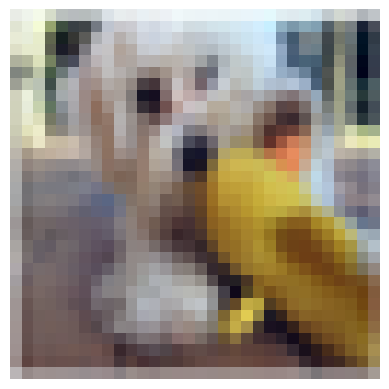

In [103]:
# -----------------------------------------------------------------------------
# Random Sample Viewer from test_loader
# -----------------------------------------------------------------------------
# - Retrieves class names from the CIFAR-10 dataset attached to test_loader.
# - Defines a helper to plot an image tensor (C x H x W) as an RGB image.
# - Randomly selects an index from the test dataset, prints the class label,
#   rescales the image to [0, 1] for visualization, and displays it.
# -----------------------------------------------------------------------------

# Class names from the dataset (e.g., ['airplane', 'automobile', ...])
classes = test_loader.dataset.classes

def plot_figure(image):
    """
    Display a tensor image in CHW format as an RGB image.

    Args:
        image (Tensor or ndarray): Image in shape (C, H, W). Values are assumed
                                   to be in [0, 1] for correct visualization.
    """
    # Matplotlib expects HWC; transpose from (C, H, W) -> (H, W, C)
    plt.imshow(np.transpose(image, (1, 2, 0)))
    plt.axis('off')
    plt.show()

# Randomly pick a sample index from the test dataset
rnd_sample_idx = np.random.randint(len(test_loader.dataset))

# Retrieve the (image, label) pair
sample_image, sample_label = test_loader.dataset[rnd_sample_idx]

# Print a clear, labeled message with the class name
print(f"[INFO] Random sample index: {rnd_sample_idx}")
print(f"[INFO] Sample class label: {sample_label} ({classes[sample_label]})")

# Rescale the image to [0, 1] for display (undo scale differences for plotting)
image = (sample_image - sample_image.min()) / (sample_image.max() - sample_image.min())

# Show the image
plot_figure(image)


#### Function Overview: Displaying Random Images per Class

The following function selects **eight random images from each class** in the dataset and displays them for visual inspection.

[INFO] Plotting grid: 8 samples x 10 classes


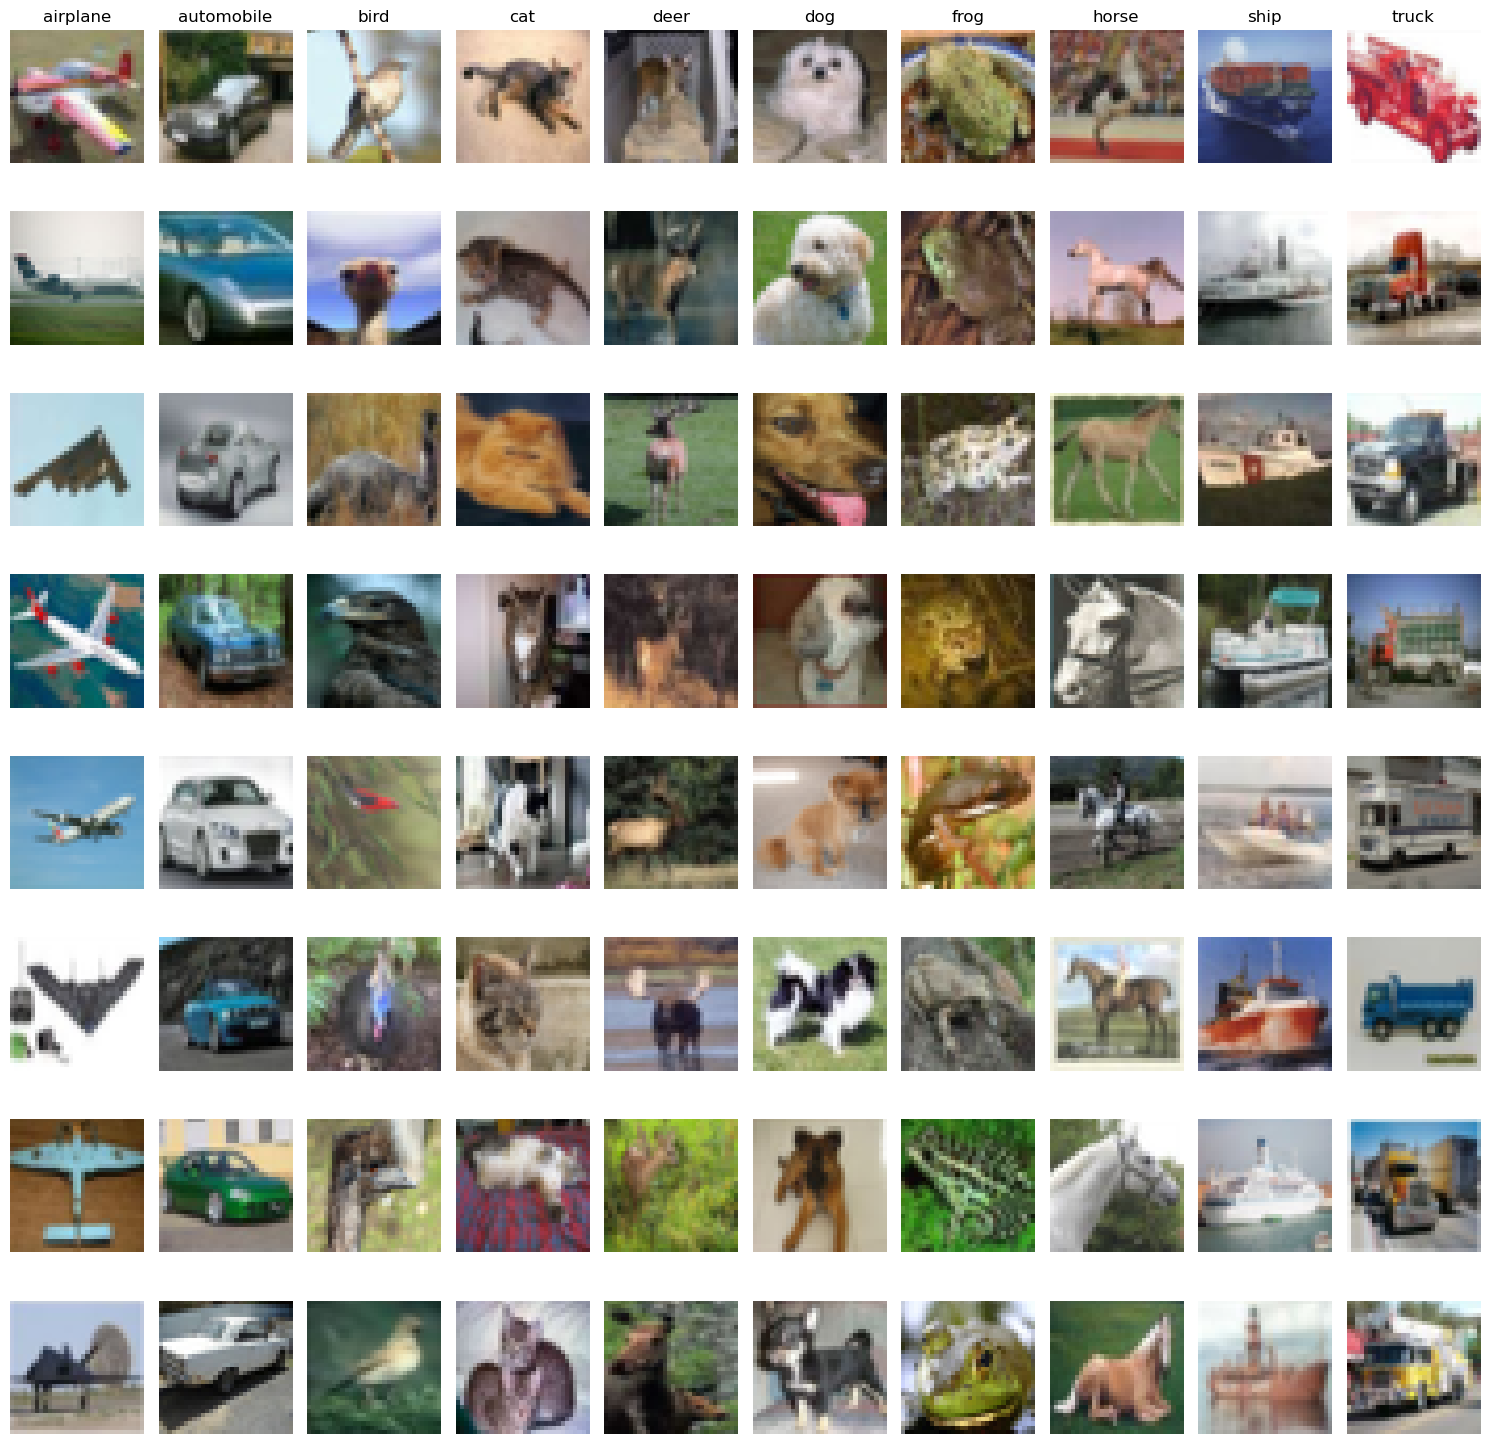

[INFO] Grid display complete.


In [104]:
# -----------------------------------------------------------------------------
# CIFAR-10 Class Grid Plotter
# -----------------------------------------------------------------------------
# This function builds a grid of images showing 8 random samples per class from
# the CIFAR-10 test dataset. It:
#   - Retrieves class names from the dataset attached to `test_loader`.
#   - Randomly selects `total_samples` indices for each class.
#   - Arranges images in a grid of `total_samples` rows x `num_classes` columns.
#   - Adds the class name as the title on the first row of each column.
#
# Notes:
# - `test_loader.dataset.data` contains raw uint8 images in HxWxC format.
# - `test_loader.dataset.targets` contains integer class labels.
# - The grid figure size can be adjusted with `plt.figure(figsize=(...))`.
# -----------------------------------------------------------------------------

def plot_cifar10_grid():
    classes = test_loader.dataset.classes  # List of class names (e.g., ['airplane', 'automobile', ...])
    total_samples = 8                      # Number of samples per class (rows)
    num_classes = len(classes)             # Number of classes (columns)

    print(f"[INFO] Plotting grid: {total_samples} samples x {num_classes} classes")
    plt.figure(figsize=(15, 15))

    # Iterate over classes by (label index, class name)
    for label, sample in enumerate(classes):
        # Find all indices for the current class in the dataset
        class_idxs = np.flatnonzero(label == np.array(test_loader.dataset.targets))

        # Randomly pick `total_samples` indices from this class (no replacement)
        sample_idxs = np.random.choice(class_idxs, total_samples, replace=False)

        # Place each selected image into the correct subplot position
        for i, idx in enumerate(sample_idxs):
            # Convert (row i, column label) into a 1-based subplot index
            plt_idx = i * num_classes + label + 1
            plt.subplot(total_samples, num_classes, plt_idx)

            # Display the raw image (uint8, H x W x C)
            plt.imshow(test_loader.dataset.data[idx])
            plt.axis('off')

            # Add the class name as the title for the first row of the column
            if i == 0:
                plt.title(sample)

    plt.tight_layout()
    plt.show()
    print("[INFO] Grid display complete.")

# Execute the grid plotting function
plot_cifar10_grid()

#### Function Description: Model Accuracy Computation (PyTorch)

This function computes the **model’s accuracy** using PyTorch.  
It takes the **model** and a **DataLoader** as parameters to iterate over the dataset in **mini-batches** while the model is in **evaluation mode**.  
During evaluation, **gradient computation is disabled** to speed up inference.  
All data and the model are moved to the selected **device** (e.g., GPU, CPU, MPS) for efficient processing.

In [105]:
# -----------------------------------------------------------------------------
# Accuracy Metric (PyTorch)
# -----------------------------------------------------------------------------
# Computes the top-1 accuracy of a classification model on the given DataLoader.
# Steps:
#   1) Switch the model to evaluation mode (model.eval()) to disable dropout, etc.
#   2) Move the model to the selected device (GPU/CPU/MPS).
#   3) Iterate over the loader in no-grad context to avoid gradient computation.
#   4) For each mini-batch, compute predictions and count correct matches.
#   5) Return overall accuracy as a float in [0.0, 1.0].
#
# Notes:
# - Inputs (xi) are cast to float32; labels (yi) are cast to long (class indices).
# - scores.max(dim=1) returns (values, indices). We use indices as predicted labels.
# - num_total accumulates batch sizes to compute the final accuracy ratio.
# -----------------------------------------------------------------------------

def accuracy(model, loader):
    num_correct = 0  # Accumulated count of correctly predicted samples
    num_total = 0    # Accumulated number of evaluated samples

    model.eval()                 # Set model to evaluation mode
    model = model.to(device=device)  # Ensure model is on the selected device

    with torch.no_grad():        # Disable gradient computation for inference
        for xi, yi in loader:
            # Move inputs and labels to device with appropriate dtypes
            xi = xi.to(device=device, dtype=torch.float32)
            yi = yi.to(device=device, dtype=torch.long)

            # Forward pass: scores shape (N, C) where C is number of classes
            scores = model(xi)

            # Predicted class is the index of the maximum score along dim=1
            _, pred = scores.max(dim=1)

            # Count correct predictions and total samples
            num_correct += (pred == yi).sum()
            num_total += pred.size(0)

        # Return accuracy as a Python float (num_correct is a tensor)
        return float(num_correct) / num_total

#### Training Function Overview

This function performs the **training process**.  
It receives the **PyTorch model**, the **optimizer**, and the **number of epochs** as parameters.  
During training, the model is moved to the selected **device**, and for each epoch the loop:

- Computes the **loss function**,
- **Clears** previously accumulated gradients,
- Executes **backpropagation**,
- **Updates** the model parameters via the optimizer step.

At the end, it **prints each epoch’s progress**.

In [106]:
# -----------------------------------------------------------------------------
# Training Loop (PyTorch)
# -----------------------------------------------------------------------------
# Trains the given model for a specified number of epochs using the provided
# optimizer. For each mini-batch, it:
#   1) Sets the model to training mode.
#   2) Moves inputs/labels to the selected device with correct dtypes.
#   3) Performs a forward pass to obtain scores (logits).
#   4) Computes cross-entropy loss.
#   5) Clears stale gradients, backpropagates, and updates parameters.
# After each epoch, it evaluates accuracy on the validation loader and prints a
# concise, labeled progress line.
# -----------------------------------------------------------------------------

def train(model, optimiser, epochs=100):
    """
    Train a PyTorch model.

    Args:
        model (nn.Module): The model to be trained.
        optimiser (torch.optim.Optimizer): Optimizer instance (e.g., SGD/Adam).
        epochs (int, optional): Number of training epochs. Defaults to 100.
    """
    # Ensure the model is on the selected device (GPU/CPU/MPS)
    model = model.to(device=device)

    for epoch in range(epochs):
        # Iterate over training mini-batches
        for i, (xi, yi) in enumerate(train_loader):
            model.train()  # Enable training-specific layers (e.g., dropout, BN)

            # Move data to device and set dtypes
            xi = xi.to(device=device, dtype=torch.float32)  # inputs
            yi = yi.to(device=device, dtype=torch.long)     # targets (class indices)

            # Forward pass: compute raw class scores (logits)
            scores = model(xi)

            # Compute cross-entropy loss between logits and ground-truth labels
            cost = F.cross_entropy(input=scores, target=yi)

            # Backpropagation step
            optimiser.zero_grad()  # Clear previously accumulated gradients
            cost.backward()        # Compute gradients
            optimiser.step()       # Update model parameters

        # Evaluate on the validation set after each epoch
        acc = accuracy(model, val_loader)

        # Labeled, well-formatted epoch summary
        print(
            f"[EPOCH] {epoch + 1:03d}/{epochs:03d} | "
            f"loss: {cost.item():.4f} | "
            f"val_accuracy: {acc:.4f}"
        )

### Linear model

#### Fully Connected Neural Network Description (PyTorch)

Using PyTorch, a **fully connected (linear) neural network** is created.  
The architecture is defined as follows:

- **Input Layer:**  
  The network receives images of size **32 × 32 × 3**, where:
  - 32 × 32 = spatial resolution  
  - 3 = RGB channels (because the images are in color)

- **First Hidden Layer (hidden1 = 256 neurons):**  
  - The flattened input is passed into a linear layer of **256 neurons**.  
  - A **ReLU** non-linear activation function is applied to introduce non-linearity.

- **Second Hidden Layer:**  
  - Takes the **256‑dimensional output** of the previous layer as input.  
  - Outputs another **256‑dimensional vector**.  
  - Again, a **ReLU** activation function is applied.

- **Output Layer:**  
  - The input is the output of the previous hidden layer.  
  - The final layer contains **10 output units**, one for each CIFAR‑10 class.

Finally, the **Adam optimizer** is used to update the model’s parameters during training.


In [107]:
# -----------------------------------------------------------------------------
# Fully Connected (Linear) Neural Network Configuration
# -----------------------------------------------------------------------------
# This block defines the hyperparameters and constructs a simple feed‑forward
# neural network using PyTorch's nn.Sequential. It includes:
#   - A flattening layer for 32×32×3 CIFAR‑10 images.
#   - Two hidden layers (256 neurons each) with ReLU activations.
#   - A final output layer of size 10 (one for each CIFAR‑10 class).
# An Adam optimizer is then initialized with the chosen learning rate.
# -----------------------------------------------------------------------------

hidden1 = 256   # Number of neurons in the first hidden layer
hidden = 256    # Number of neurons in the second hidden layer
lr = 0.001       # Learning rate for the optimizer
epochs = 10      # Number of training epochs

# Model definition using nn.Sequential for readability
model1 = nn.Sequential(
    nn.Flatten(),                                           # Convert image to 1D vector
    nn.Linear(in_features=32*32*3, out_features=hidden1),   # First hidden layer
    nn.ReLU(),                                              # Activation function
    nn.Linear(in_features=hidden1, out_features=hidden),    # Second hidden layer
    nn.ReLU(),                                              # Activation function
    nn.Linear(in_features=hidden, out_features=10)          # Output layer (10 classes)
)

# Adam optimizer for updating model parameters
optimiser = torch.optim.Adam(model1.parameters(), lr=lr)

# Informative output
print("[INFO] Model configuration completed.")
print(f"[INFO] Hidden layers: {hidden1}, {hidden}")
print(f"[INFO] Learning rate: {lr}")
print(f"[INFO] Epochs: {epochs}")

[INFO] Model configuration completed.
[INFO] Hidden layers: 256, 256
[INFO] Learning rate: 0.001
[INFO] Epochs: 10


#### Executing the Training Process

The training process for our neural network is now being executed.

In [108]:
train(model1, optimiser, epochs)

[EPOCH] 001/010 | loss: 1.0515 | val_accuracy: 0.4656
[EPOCH] 002/010 | loss: 1.7065 | val_accuracy: 0.4800
[EPOCH] 003/010 | loss: 1.4346 | val_accuracy: 0.5020
[EPOCH] 004/010 | loss: 1.4454 | val_accuracy: 0.5130
[EPOCH] 005/010 | loss: 1.4526 | val_accuracy: 0.5142
[EPOCH] 006/010 | loss: 0.8295 | val_accuracy: 0.5228
[EPOCH] 007/010 | loss: 1.6063 | val_accuracy: 0.5274
[EPOCH] 008/010 | loss: 1.1887 | val_accuracy: 0.5142
[EPOCH] 009/010 | loss: 1.4607 | val_accuracy: 0.5284
[EPOCH] 010/010 | loss: 1.0423 | val_accuracy: 0.5278


#### Training Results Summary

The process concludes with an approximate accuracy of ~**53%**.  
While this is not a high score, it does indicate that the model is **learning meaningful patterns** from the data rather than simply guessing at random.


### Sequential CNN

#### CNN Architecture Overview

Now, using a **Convolutional Neural Network (CNN)**, we will implement **three layers**: the first **two are convolutional layers**, followed by a **final output layer**.

- **First Convolutional Layer:**  
  Apply **16 filters** with the following parameters:  
  - **Input channels:** 3 (RGB)  
  - **Output channels:** 16 (variable `channel1`)  
  - **Kernel size:** 3×3  
  - **Padding:** 1 (to preserve spatial dimensions)  
  - **Activation:** **ReLU**

- **Second Convolutional Layer:**  
  Apply **32 filters** with the following parameters:  
  - **Input channels:** 16 (output of the previous layer)  
  - **Output channels:** 32 (variable `channel2`)  
  - **Kernel size:** 3×3  
  - **Padding:** 1 (to preserve spatial dimensions)  
  - **Activation:** **ReLU**

- **Dimensionality Reduction:**  
  Add a **Max Pooling** layer with a **2×2 kernel** and **stride = 2** to downsample the feature maps.

- **Flattening:**  
  Convert the resulting volume (**16 × 16 × 32**) into a feature vector using **Flatten**.

- **Output Layer & Optimization:**  
  Apply a **fully connected output layer with 10 neurons** (one per class) and optimize the parameters using **Adam**.

In [109]:
# -----------------------------------------------------------------------------
# Convolutional Neural Network (PyTorch) – Configuration and Definition
# -----------------------------------------------------------------------------
# Goal: Implement a CNN whose accuracy should surpass that of the linear model.
#
# Architecture:
#   - Conv2d(3 -> channel1, kernel=3, padding=1) + ReLU
#   - Conv2d(channel1 -> channel2, kernel=3, padding=1) + ReLU
#   - MaxPool2d(kernel=2, stride=2)  # Downsamples H and W by 2
#   - Flatten()
#   - Linear(16*16*channel2 -> 10)   # 10 classes for CIFAR-10
#
# Notes:
# - Input images are 32x32 RGB (3 channels).
# - Two conv layers with padding=1 preserve spatial size (32x32) before pooling.
# - Max pooling reduces 32x32 -> 16x16.
# - Flatten converts (C, H, W) = (channel2, 16, 16) to a vector of length 16*16*channel2.
# - Adam optimizer is used with a small learning rate for stable training.
# -----------------------------------------------------------------------------

# Hyperparameters
channel1 = 16   # Number of filters in the first convolutional layer
channel2 = 32   # Number of filters in the second convolutional layer
epochs = 10     # Number of training epochs
lr = 0.0001     # Learning rate for Adam

# CNN model definition
modelCNN1 = nn.Sequential(
    # Conv block 1
    nn.Conv2d(in_channels=3, out_channels=channel1, kernel_size=3, padding=1),
    nn.ReLU(),

    # Conv block 2
    nn.Conv2d(in_channels=channel1, out_channels=channel2, kernel_size=3, padding=1),
    nn.ReLU(),

    # Downsampling
    nn.MaxPool2d(kernel_size=2, stride=2),

    # Classifier head
    nn.Flatten(),
    nn.Linear(in_features=16 * 16 * channel2, out_features=10)
)

# Optimizer
optimiser = torch.optim.Adam(modelCNN1.parameters(), lr)

# Informative configuration printout
print("[CONFIG] CNN model created.")
print(f"[CONFIG] Conv1 out_channels: {channel1}, Conv2 out_channels: {channel2}")
print(f"[CONFIG] After MaxPool: feature map size -> 16x16, flattened -> {16*16*channel2}")
print(f"[CONFIG] Output classes: 10")
print(f"[CONFIG] Optimizer: Adam | Learning rate: {lr}")
print(f"[CONFIG] Planned epochs: {epochs}")

[CONFIG] CNN model created.
[CONFIG] Conv1 out_channels: 16, Conv2 out_channels: 32
[CONFIG] After MaxPool: feature map size -> 16x16, flattened -> 8192
[CONFIG] Output classes: 10
[CONFIG] Optimizer: Adam | Learning rate: 0.0001
[CONFIG] Planned epochs: 10


#### Executing the CNN Training Process

The training process for our **Convolutional Neural Network (CNN)** is now being executed.

In [110]:
train(modelCNN1, optimiser, epochs)

[EPOCH] 001/010 | loss: 1.5172 | val_accuracy: 0.4792
[EPOCH] 002/010 | loss: 1.2741 | val_accuracy: 0.5278
[EPOCH] 003/010 | loss: 1.1969 | val_accuracy: 0.5618
[EPOCH] 004/010 | loss: 1.1058 | val_accuracy: 0.5832
[EPOCH] 005/010 | loss: 0.8676 | val_accuracy: 0.5886
[EPOCH] 006/010 | loss: 0.7839 | val_accuracy: 0.5956
[EPOCH] 007/010 | loss: 1.0287 | val_accuracy: 0.6152
[EPOCH] 008/010 | loss: 0.8571 | val_accuracy: 0.6210
[EPOCH] 009/010 | loss: 0.8421 | val_accuracy: 0.6252
[EPOCH] 010/010 | loss: 0.6580 | val_accuracy: 0.6288


#### CNN Training Results Summary

The process concludes with an accuracy of ~**63%**, representing an improvement of nearly **10%** compared to our previous neural network model.

#### Object-Oriented Programming (OOP) Approach

Now we will apply **Object-Oriented Programming (OOP)** to improve the implementation of our Convolutional Neural Network.

1. A class is created that **inherits from `nn.Module`** in PyTorch.  
2. In the constructor, the number of **input and output channels** for both the first and second convolutional layers is passed as parameters.  
3. Inside the class, the same structures used in the previous implementation are defined.  
4. The activation function (**ReLU**) will be applied separately rather than defined inside the constructor.  
5. A `forward` function is implemented, which takes the **input volume** as its argument.  
6. Inside the `forward` function, the activation function (**ReLU** in this case) is applied to the outputs of the convolutional layers.

In [111]:
# -----------------------------------------------------------------------------
# CNN_class1: Object-Oriented CNN Definition (PyTorch)
# -----------------------------------------------------------------------------
# This class implements a simple Convolutional Neural Network with:
#   - Two convolutional layers (3x3 kernels, padding=1 to preserve spatial size)
#   - ReLU activations applied in the forward pass
#   - A 2x2 Max Pooling layer (stride=2) to downsample feature maps
#   - A Flatten layer to convert (C, H, W) into a 1D vector
#   - A fully connected (linear) layer producing logits for 10 classes (CIFAR-10)
#
# Expected input:
#   - A batch of RGB images with shape (N, 3, 32, 32) where:
#       N = batch size, 3 = channels, 32x32 = spatial dimensions.
# After two conv layers (with padding=1) and a 2x2 max pool:
#   - Spatial dims: 32x32 -> 16x16
#   - Channels: in_channel -> channel1 -> channel2
#   - Flattened size: 16 * 16 * channel2
#
# Notes:
# - The class inherits from nn.Module following PyTorch’s OOP pattern.
# - The ReLU activation is applied explicitly in the forward pass (not in __init__).
# -----------------------------------------------------------------------------

class CNN_class1(nn.Module):
    def __init__(self, in_channel, channel1, channel2):
        """
        Initialize layers for a two-conv CNN.

        Args:
            in_channel (int): Number of input channels (e.g., 3 for RGB).
            channel1 (int): Number of output channels for the first conv layer.
            channel2 (int): Number of output channels for the second conv layer.
        """
        super().__init__()

        # Convolutional layer 1: preserves HxW with padding=1 for 3x3 kernels
        self.conv1 = nn.Conv2d(
            in_channels=in_channel,
            out_channels=channel1,
            kernel_size=3,
            padding=1
        )

        # Convolutional layer 2: takes channel1 maps as input, outputs channel2 maps
        self.conv2 = nn.Conv2d(
            in_channels=channel1,
            out_channels=channel2,
            kernel_size=3,
            padding=1
        )

        # Max pooling: downsample spatial dimensions by a factor of 2 (32->16)
        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Fully connected (classifier) layer:
        # input features = 16 * 16 * channel2 after pooling
        self.fc = nn.Linear(in_features=16 * 16 * channel2, out_features=10)

        # Flatten feature maps into (N, C*H*W) before feeding to the linear layer
        self.flatten = nn.Flatten()

    def forward(self, x):
        """
        Forward pass through the network.

        Steps:
          1) conv1 -> ReLU
          2) conv2 -> ReLU
          3) 2x2 MaxPool (downsample)
          4) Flatten
          5) Fully connected classifier (logits for 10 classes)

        Args:
            x (Tensor): Input batch of images with shape (N, in_channel, 32, 32).

        Returns:
            Tensor: Logits with shape (N, 10).
        """
        # Apply first convolution + ReLU, then second convolution + ReLU
        x = F.relu(self.conv2(F.relu(self.conv1(x))))

        # Downsample spatial dimensions (H, W) by 2
        x = self.max_pool(x)

        # Flatten to (N, 16*16*channel2)
        x = self.flatten(x)

        # Linear classifier producing class logits
        return self.fc(x)

#### Instantiating the `CNN_class1` Model

The `CNN_class1` class is now instantiated, passing the required parameters so it can be executed with the same configuration as the previous implementation.  
This object‑oriented version is **functionally equivalent** to the earlier `nn.Sequential` CNN model, but provides better structure, readability, and extensibility.

In [112]:
# -----------------------------------------------------------------------------
# Instantiate CNN_class1 and Configure Training Parameters
# -----------------------------------------------------------------------------
# This block initializes the second CNN model (OOP version) using the
# CNN_class1 class defined earlier. The architecture matches the previous
# nn.Sequential CNN but uses an object-oriented structure for better
# organization and extensibility.
#
# Steps:
#   1) Set hyperparameters (channels, epochs, learning rate).
#   2) Instantiate the CNN_class1 model with input channels = 3 (RGB images).
#   3) Initialize the Adam optimizer with the specified learning rate.
#   4) Provide clear console output confirming successful configuration.
# -----------------------------------------------------------------------------

channel1 = 16        # Number of filters in the first convolutional layer
channel2 = 32        # Number of filters in the second convolutional layer
epochs = 10          # Training epochs
lr = 0.0001          # Learning rate

# Instantiate the OOP-based CNN model (equivalent to previous Sequential model)
modelCNN2 = CNN_class1(3, channel1, channel2)

# Adam optimizer for model parameter updates
optimiser = torch.optim.Adam(modelCNN2.parameters(), lr)

# Informative output
print("[CONFIG] OOP-based CNN model (modelCNN2) instantiated successfully.")
print(f"[CONFIG] Conv1 filters: {channel1}, Conv2 filters: {channel2}")
print(f"[CONFIG] Learning rate: {lr}")
print(f"[CONFIG] Training epochs: {epochs}")

[CONFIG] OOP-based CNN model (modelCNN2) instantiated successfully.
[CONFIG] Conv1 filters: 16, Conv2 filters: 32
[CONFIG] Learning rate: 0.0001
[CONFIG] Training epochs: 10


#### Executing the CNN Training (Object-Oriented Implementation)

The training process for our **Convolutional Neural Network (CNN)**, implemented using an object‑oriented approach, is now being executed.

In [113]:
train(modelCNN2, optimiser, epochs)

[EPOCH] 001/010 | loss: 1.4683 | val_accuracy: 0.4860
[EPOCH] 002/010 | loss: 1.3857 | val_accuracy: 0.5304
[EPOCH] 003/010 | loss: 1.3397 | val_accuracy: 0.5580
[EPOCH] 004/010 | loss: 1.3130 | val_accuracy: 0.5716
[EPOCH] 005/010 | loss: 0.5804 | val_accuracy: 0.5874
[EPOCH] 006/010 | loss: 0.8698 | val_accuracy: 0.6018
[EPOCH] 007/010 | loss: 1.4337 | val_accuracy: 0.6094
[EPOCH] 008/010 | loss: 1.2843 | val_accuracy: 0.6238
[EPOCH] 009/010 | loss: 1.4704 | val_accuracy: 0.6320
[EPOCH] 010/010 | loss: 0.7298 | val_accuracy: 0.6370


#### Final Accuracy Summary (OOP CNN)

The process concludes with an accuracy of **62%**, which is very similar to the previous result.  
This is expected since only the **implementation style** changed—moving from a sequential model to an object‑oriented one—while the **architecture itself remained the same**.

#### Anonymous Function for Convolution Operation

Here we create an object that stores an **anonymous function**, which receives the parameters for **layer 1 and layer 2** and returns the result of applying a convolution operation using a **kernel size of 3** and **padding of 1**.

In [114]:
# -----------------------------------------------------------------------------
# Anonymous Convolution Function (Kernel Size 3, Padding 1)
# -----------------------------------------------------------------------------
# This lambda function creates a 2D convolutional layer with:
#   - Input channels  = channel1
#   - Output channels = channel2
#   - Kernel size     = 3x3
#   - Padding         = 1 (keeps spatial dimensions unchanged)
#
# Purpose:
#   - Provides a compact way to generate Conv2d layers with fixed parameters.
#   - Useful for cleaner, more modular CNN definitions.
# -----------------------------------------------------------------------------

conv_k_3 = lambda channel1, channel2: nn.Conv2d(
    channel1, 
    channel2, 
    kernel_size=3, 
    padding=1
)

# Example usage output (informational only)
print("[INFO] Anonymous convolution function (conv_k_3) created.")
print("[INFO] It returns Conv2d layers with kernel_size=3 and padding=1.")

[INFO] Anonymous convolution function (conv_k_3) created.
[INFO] It returns Conv2d layers with kernel_size=3 and padding=1.


#### Implementing `CNN_class2` Using the Anonymous Function

Now, using the previously defined anonymous function, we implement the `CNN_class2` class to simplify and streamline the CNN architecture definition.  

In addition, we introduce a key improvement: **initializing the network parameters using Kaiming Uniform initialization**, which helps enhance training performance for networks that use **ReLU** activations.  

This showcases one of the advantages of using an **object‑oriented approach**—the ability to easily customize and modify components of the neural network architecture.

In [115]:
# -----------------------------------------------------------------------------
# CNN_class2: OOP CNN with Reusable Conv Factory and Kaiming Initialization
# -----------------------------------------------------------------------------
# This class defines a Convolutional Neural Network similar to CNN_class1 but:
#   - Uses the reusable anonymous factory `conv_k_3` for 3x3 conv layers (pad=1).
#   - Initializes the first conv layer with Kaiming Uniform initialization,
#     which is well-suited for ReLU activations.
#   - Maintains the same overall architecture:
#       Conv(3x3) -> ReLU -> Conv(3x3) -> ReLU -> MaxPool(2x2) -> Flatten -> Linear(10)
#
# Expected input:
#   - A batch of images shaped (N, in_channel, 32, 32).
# After MaxPool(2x2), spatial dims go from 32x32 to 16x16.
# The final Linear layer therefore receives 16*16*channel2 features.
# -----------------------------------------------------------------------------

class CNN_class2(nn.Module):
    
    def __init__(self, in_channel, channel1, channel2):
        """
        Initialize layers using a small conv factory and Kaiming init.

        Args:
            in_channel (int): Number of input channels (e.g., 3 for RGB).
            channel1 (int): Output channels for the first conv layer.
            channel2 (int): Output channels for the second conv layer.
        """
        super().__init__()

        # First 3x3 conv (padding=1 keeps spatial dimensions)
        self.conv1 = conv_k_3(in_channel, channel1)

        # Kaiming uniform initialization for conv1 weights (good for ReLU)
        nn.init.kaiming_uniform_(self.conv1.weight)

        # Second 3x3 conv (also padding=1)
        self.conv2 = conv_k_3(channel1, channel2)

        # 2x2 max pooling with stride 2 halves H and W: 32 -> 16
        self.max_pool = nn.MaxPool2d(2, 2)

        # Fully connected classifier (CIFAR-10 -> 10 classes)
        self.fc = nn.Linear(in_features=16 * 16 * channel2, out_features=10)

        # Flatten to (N, C*H*W) before feeding into the linear layer
        self.flatten = nn.Flatten()

        # Informative configuration printout
        print("[CONFIG] CNN_class2 initialized.")
        print(f"[CONFIG] conv1: in={in_channel}, out={channel1}, kernel=3, padding=1 (Kaiming init)")
        print(f"[CONFIG] conv2: in={channel1}, out={channel2}, kernel=3, padding=1")
        print(f"[CONFIG] After MaxPool: feature map size -> 16x16; flattened -> {16*16*channel2}")
        print("[CONFIG] Output classes: 10")

    def forward(self, x):
        """
        Forward pass:
          conv1 -> ReLU -> conv2 -> ReLU -> MaxPool(2x2) -> Flatten -> Linear(10)

        Args:
            x (Tensor): Input batch with shape (N, in_channel, 32, 32).

        Returns:
            Tensor: Logits of shape (N, 10).
        """
        # Apply first and second conv layers with ReLU activations
        x = F.relu(self.conv2(F.relu(self.conv1(x))))

        # Downsample spatial dimensions
        x = self.max_pool(x)

        # Flatten and classify
        x = self.flatten(x)

        return self.fc(x)


#### Instantiating the `CNN_class2` Model

The `CNN_class2` class is now instantiated to create a new CNN model instance using the improved architecture and Kaiming initialization.

In [116]:
# -----------------------------------------------------------------------------
# Instantiate CNN_class2 and Configure Training Settings
# -----------------------------------------------------------------------------
# This block initializes the third CNN model (modelCNN3) using CNN_class2,
# which incorporates:
#   - Modular convolution creation via conv_k_3
#   - Kaiming initialization for improved training stability
#
# Steps:
#   1) Define hyperparameters (channels, epochs, learning rate)
#   2) Instantiate the CNN_class2 model with input channels = 3 (RGB)
#   3) Initialize Adam optimizer with the defined learning rate
#   4) Print structured configuration output for clarity
# -----------------------------------------------------------------------------

channel1 = 16        # Number of filters in the first convolutional layer
channel2 = 32        # Number of filters in the second convolutional layer
epochs = 10          # Number of training epochs
lr = 0.0001          # Learning rate for Adam optimizer

# Instantiate model with Kaiming-initialized Conv layers
modelCNN3 = CNN_class2(3, channel1, channel2)

# Create Adam optimizer for model parameters
optimiser = torch.optim.Adam(modelCNN3.parameters(), lr)

# Informative configuration printout
print("[CONFIG] OOP-based CNN model (modelCNN3) instantiated successfully.")
print(f"[CONFIG] conv1 filters: {channel1}, conv2 filters: {channel2}")
print(f"[CONFIG] Learning rate: {lr}")
print(f"[CONFIG] Training epochs: {epochs}")

[CONFIG] CNN_class2 initialized.
[CONFIG] conv1: in=3, out=16, kernel=3, padding=1 (Kaiming init)
[CONFIG] conv2: in=16, out=32, kernel=3, padding=1
[CONFIG] After MaxPool: feature map size -> 16x16; flattened -> 8192
[CONFIG] Output classes: 10
[CONFIG] OOP-based CNN model (modelCNN3) instantiated successfully.
[CONFIG] conv1 filters: 16, conv2 filters: 32
[CONFIG] Learning rate: 0.0001
[CONFIG] Training epochs: 10


#### Final Accuracy Summary (CNN_class2)

The process concludes with an accuracy of ~**65%**, which is a very similar result to the previous model but shows a slight improvement thanks to the enhanced implementation.

In [117]:
train(modelCNN3, optimiser, epochs)

[EPOCH] 001/010 | loss: 1.4566 | val_accuracy: 0.4982
[EPOCH] 002/010 | loss: 0.9149 | val_accuracy: 0.5534
[EPOCH] 003/010 | loss: 1.3690 | val_accuracy: 0.5632
[EPOCH] 004/010 | loss: 0.8030 | val_accuracy: 0.5988
[EPOCH] 005/010 | loss: 1.1823 | val_accuracy: 0.5982
[EPOCH] 006/010 | loss: 0.9482 | val_accuracy: 0.6118
[EPOCH] 007/010 | loss: 0.9043 | val_accuracy: 0.6230
[EPOCH] 008/010 | loss: 1.2062 | val_accuracy: 0.6310
[EPOCH] 009/010 | loss: 0.6365 | val_accuracy: 0.6438
[EPOCH] 010/010 | loss: 1.0252 | val_accuracy: 0.6512


#### Input Normalization with Batch Normalization

To further improve model performance, we normalize the input data between each layer so that the **mean is forced to zero** and the **standard deviation to one**.  
This technique helps stabilize and accelerate training.

Here, **Batch Normalization** is added to the network to automatically perform this normalization across mini-batches, resulting in smoother gradients and better overall model performance.

In [118]:
# -----------------------------------------------------------------------------
# CNN_class3: CNN with Batch Normalization (PyTorch, OOP)
# -----------------------------------------------------------------------------
# This class extends the previous CNN designs by introducing Batch Normalization
# after each convolutional layer. BatchNorm helps stabilize activations by
# normalizing intermediate feature distributions, which can:
#   - Accelerate convergence,
#   - Improve training stability,
#   - Potentially boost model accuracy.
#
# Architecture:
#   Conv(3x3) -> BN -> ReLU -> Conv(3x3) -> BN -> ReLU -> MaxPool(2x2) -> Flatten -> Linear(10)
#
# Input:
#   - A batch of images with shape (N, in_channel, 32, 32).
# After MaxPool(2x2), spatial dimensions reduce from 32x32 to 16x16.
# The final Linear layer receives 16 * 16 * channel2 features.
# -----------------------------------------------------------------------------

class CNN_class3(nn.Module):
    def __init__(self, in_channel, channel1, channel2):
        """
        Initialize a two-convolution CNN with Batch Normalization.

        Args:
            in_channel (int): Number of input channels (e.g., 3 for RGB).
            channel1 (int): Output channels for the first conv layer.
            channel2 (int): Output channels for the second conv layer.
        """
        super().__init__()

        # First convolution (3x3, padding=1 preserves HxW)
        self.conv1 = conv_k_3(in_channel, channel1)
        # Batch normalization for the first conv's output feature maps
        self.bn1 = nn.BatchNorm2d(channel1)

        # Second convolution (3x3, padding=1)
        self.conv2 = conv_k_3(channel1, channel2)
        # Batch normalization for the second conv's output feature maps
        self.bn2 = nn.BatchNorm2d(channel2)

        # Downsampling: halves spatial dimensions (32 -> 16)
        self.max_pool = nn.MaxPool2d(2, 2)

        # Classifier head (CIFAR-10 -> 10 classes)
        self.fc = nn.Linear(in_features=16 * 16 * channel2, out_features=10)

        # Flatten from (N, C, H, W) to (N, C*H*W)
        self.flatten = nn.Flatten()

        # Informative configuration printout
        print("[CONFIG] CNN_class3 initialized with BatchNorm.")
        print(f"[CONFIG] conv1: in={in_channel}, out={channel1}, kernel=3, padding=1 + BN")
        print(f"[CONFIG] conv2: in={channel1}, out={channel2}, kernel=3, padding=1 + BN")
        print(f"[CONFIG] After MaxPool: feature map size -> 16x16; flattened -> {16*16*channel2}")
        print("[CONFIG] Output classes: 10")

    def forward(self, x):
        """
        Forward pass:
          conv1 -> BN -> ReLU -> conv2 -> BN -> ReLU -> MaxPool -> Flatten -> Linear

        Args:
            x (Tensor): Input batch of images (N, in_channel, 32, 32).

        Returns:
            Tensor: Logits of shape (N, 10).
        """
        # Block 1: Conv -> BN -> ReLU
        x = F.relu(self.bn1(self.conv1(x)))

        # Block 2: Conv -> BN -> ReLU
        x = F.relu(self.bn2(self.conv2(x)))

        # Downsample spatial dimensions
        x = self.max_pool(x)

        # Flatten and classify
        x = self.flatten(x)
        return self.fc(x)

#### Instantiating the `CNN_class3` Model

The `CNN_class3` class is now instantiated to create a CNN model that incorporates **Batch Normalization** for improved stability and training performance.

In [119]:
# -----------------------------------------------------------------------------
# Instantiate CNN_class3 and Set Training Hyperparameters
# -----------------------------------------------------------------------------
# This block creates an instance of CNN_class3, the BatchNorm-enhanced CNN, and
# initializes the Adam optimizer. The architecture remains:
#   Conv -> BN -> ReLU -> Conv -> BN -> ReLU -> MaxPool -> Flatten -> Linear(10)
#
# Steps:
#   1) Define model hyperparameters (channels, epochs, learning rate)
#   2) Instantiate the CNN_class3 model for RGB images (3 input channels)
#   3) Attach an Adam optimizer with the specified learning rate
#   4) Print configuration details for clarity
# -----------------------------------------------------------------------------

channel1 = 16       # Number of filters in the first convolutional layer
channel2 = 32       # Number of filters in the second convolutional layer
epochs = 10         # Total training epochs planned
lr = 0.0001         # Adam learning rate

# Create model instance with Batch Normalization
modelCNN4 = CNN_class3(3, channel1, channel2)

# Adam optimizer for model parameters
optimiser = torch.optim.Adam(modelCNN4.parameters(), lr)

# Informative configuration output
print("[CONFIG] BatchNorm-enhanced CNN (modelCNN4) instantiated successfully.")
print(f"[CONFIG] Conv1 filters: {channel1}, Conv2 filters: {channel2}")
print(f"[CONFIG] Learning rate: {lr}")
print(f"[CONFIG] Training epochs: {epochs}")

[CONFIG] CNN_class3 initialized with BatchNorm.
[CONFIG] conv1: in=3, out=16, kernel=3, padding=1 + BN
[CONFIG] conv2: in=16, out=32, kernel=3, padding=1 + BN
[CONFIG] After MaxPool: feature map size -> 16x16; flattened -> 8192
[CONFIG] Output classes: 10
[CONFIG] BatchNorm-enhanced CNN (modelCNN4) instantiated successfully.
[CONFIG] Conv1 filters: 16, Conv2 filters: 32
[CONFIG] Learning rate: 0.0001
[CONFIG] Training epochs: 10


#### Final Accuracy Summary (CNN_class3)

The process concludes with an accuracy of **68%**, showing a noticeable improvement over previous models thanks to the use of **Batch Normalization**, which helps stabilize learning and enhance model performance.

In [120]:
train(modelCNN4, optimiser, epochs)

[EPOCH] 001/010 | loss: 1.1177 | val_accuracy: 0.5672
[EPOCH] 002/010 | loss: 1.1169 | val_accuracy: 0.6004
[EPOCH] 003/010 | loss: 0.7931 | val_accuracy: 0.6406
[EPOCH] 004/010 | loss: 0.8975 | val_accuracy: 0.6494
[EPOCH] 005/010 | loss: 0.8004 | val_accuracy: 0.6566
[EPOCH] 006/010 | loss: 0.8697 | val_accuracy: 0.6664
[EPOCH] 007/010 | loss: 0.7847 | val_accuracy: 0.6532
[EPOCH] 008/010 | loss: 0.8630 | val_accuracy: 0.6718
[EPOCH] 009/010 | loss: 0.6332 | val_accuracy: 0.6690
[EPOCH] 010/010 | loss: 0.4225 | val_accuracy: 0.6744


#### Combining OOP and Sequential Implementations

Finally, the class‑based approach is combined with a **sequential‑style architecture**.  
A **4‑layer convolutional network** is implemented using the following repeated structure:

**Convolutional Layer → Batch Normalization → ReLU → Convolutional Layer → Batch Normalization → Max Pooling**

This block is repeated **twice**, applying **Max Pooling after every two convolutional layers**, allowing the model to progressively reduce spatial dimensions while deepening feature extraction.

In [121]:
# -----------------------------------------------------------------------------
# CNN_class4: Two-Conv Block with BatchNorm and MaxPooling (PyTorch, OOP)
# -----------------------------------------------------------------------------
# This class defines a compact CNN block that combines:
#   Conv(3x3) -> BatchNorm -> ReLU -> Conv(3x3) -> BatchNorm -> ReLU -> MaxPool(2x2)
#
# Intended usage:
#   - This module can be stacked/repeated to build deeper CNNs.
#   - Each instance reduces spatial dimensions by a factor of 2 due to MaxPool.
#
# Notes:
#   - Convolutions are created via the reusable conv_k_3 factory (kernel=3, pad=1).
#   - BatchNorm stabilizes activations and can speed up convergence.
# -----------------------------------------------------------------------------

class CNN_class4(nn.Module):
    def __init__(self, in_channel, channel1, channel2):
        """
        Initialize a two-convolution block with BatchNorm and MaxPooling.

        Args:
            in_channel (int): Number of input channels (e.g., 3 for RGB).
            channel1  (int): Output channels for the first convolution.
            channel2  (int): Output channels for the second convolution.
        """
        super().__init__()

        # First convolution + BatchNorm
        self.conv1 = conv_k_3(in_channel, channel1)    # 3x3 conv, padding=1
        self.bn1   = nn.BatchNorm2d(channel1)          # BN over channel1 feature maps

        # Second convolution + BatchNorm
        self.conv2 = conv_k_3(channel1, channel2)      # 3x3 conv, padding=1
        self.bn2   = nn.BatchNorm2d(channel2)          # BN over channel2 feature maps
        
        # Downsampling: halves H and W (e.g., 32 -> 16)
        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Informational printout for configuration clarity
        print("[CONFIG] CNN_class4 initialized.")
        print(f"[CONFIG] conv1: in={in_channel}, out={channel1}, kernel=3, padding=1 + BN + ReLU")
        print(f"[CONFIG] conv2: in={channel1}, out={channel2}, kernel=3, padding=1 + BN + ReLU")
        print("[CONFIG] Tail: MaxPool(2x2) for spatial downsampling")

    def forward(self, x):
        """
        Forward pass:
          conv1 -> BN -> ReLU -> conv2 -> BN -> ReLU -> MaxPool

        Args:
            x (Tensor): Input tensor of shape (N, in_channel, H, W).

        Returns:
            Tensor: Output tensor after two conv-BN-ReLU blocks and MaxPool.
        """
        # First block: Conv -> BN -> ReLU
        x = F.relu(self.bn1(self.conv1(x)))

        # Second block: Conv -> BN -> ReLU
        x = F.relu(self.bn2(self.conv2(x)))

        # Downsample spatial dimensions
        return self.max_pool(x)

#### Integrating `CNN_class4` Inside `nn.Sequential`

The `CNN_class4` class is now instantiated and embedded within an `nn.Sequential` container.  
This allows both implementations—object‑oriented and sequential—to be combined, creating a **reusable, modular, and scalable** CNN architecture.

In [122]:
# -----------------------------------------------------------------------------
# Build a Modular CNN by Combining OOP Blocks with nn.Sequential
# -----------------------------------------------------------------------------
# Architecture overview:
#   - Stack two CNN_class4 blocks (each: Conv -> BN -> ReLU -> Conv -> BN -> ReLU -> MaxPool)
#   - After two blocks, spatial dims reduce as follows for 32x32 input:
#       Block 1 MaxPool: 32x32 -> 16x16
#       Block 2 MaxPool: 16x16 ->  8x8
#   - Flatten the resulting feature maps
#   - Linear classifier with 10 outputs (CIFAR‑10 classes)
#
# Notes:
# - Channels per block:
#     * Block 1: in=3 -> mid=channel1 -> out=channel2
#     * Block 2: in=channel2 -> mid=channel4 -> out=channel4
# - Final Flatten size = 8 * 8 * channel4 (since two 2x2 pools were applied)
# - Adam optimizer is configured with the given learning rate.
# -----------------------------------------------------------------------------

channel1 = 16     # First block: conv1 out_channels
channel2 = 32     # First block: conv2 out_channels (and input to next block)
channel3 = 64     # (Declared but unused in this configuration; kept for parity)
channel4 = 128    # Second block: conv2 out_channels (and final feature channels)
epochs = 10       # Training epochs
lr = 0.001        # Learning rate

# Model definition using nn.Sequential with OOP blocks
modelCNN5 = nn.Sequential(
    CNN_class4(3, channel1, channel2),              # Block 1: 3 -> 16 -> 32, then MaxPool (32->16)
    CNN_class4(channel2, channel4, channel4),       # Block 2: 32 -> 128 -> 128, then MaxPool (16->8)
    nn.Flatten(),                                    # Flatten (N, 128, 8, 8) -> (N, 8*8*128)
    nn.Linear(in_features=8 * 8 * channel4, out_features=10)  # Classifier head
)

# Optimizer: Adam
optimiser = torch.optim.Adam(modelCNN5.parameters(), lr)

# ----------------------------------------------------------------------------- 
# Informative configuration printout
# -----------------------------------------------------------------------------
print("[CONFIG] Combined CNN (modelCNN5) created using nn.Sequential + CNN_class4 blocks.")
print(f"[CONFIG] Block 1 channels: in=3 -> {channel1} -> {channel2}")
print(f"[CONFIG] Block 2 channels: in={channel2} -> {channel4} -> {channel4}")
print(f"[CONFIG] Post-pooling feature map size: 8x8; flattened size: {8*8*channel4}")
print(f"[CONFIG] Output classes: 10")
print(f"[CONFIG] Optimizer: Adam | Learning rate: {lr}")
print(f"[CONFIG] Planned epochs: {epochs}")

[CONFIG] CNN_class4 initialized.
[CONFIG] conv1: in=3, out=16, kernel=3, padding=1 + BN + ReLU
[CONFIG] conv2: in=16, out=32, kernel=3, padding=1 + BN + ReLU
[CONFIG] Tail: MaxPool(2x2) for spatial downsampling
[CONFIG] CNN_class4 initialized.
[CONFIG] conv1: in=32, out=128, kernel=3, padding=1 + BN + ReLU
[CONFIG] conv2: in=128, out=128, kernel=3, padding=1 + BN + ReLU
[CONFIG] Tail: MaxPool(2x2) for spatial downsampling
[CONFIG] Combined CNN (modelCNN5) created using nn.Sequential + CNN_class4 blocks.
[CONFIG] Block 1 channels: in=3 -> 16 -> 32
[CONFIG] Block 2 channels: in=32 -> 128 -> 128
[CONFIG] Post-pooling feature map size: 8x8; flattened size: 8192
[CONFIG] Output classes: 10
[CONFIG] Optimizer: Adam | Learning rate: 0.001
[CONFIG] Planned epochs: 10


#### Training Execution

The training process is now being executed.

In [123]:
train(modelCNN5, optimiser, epochs)

[EPOCH] 001/010 | loss: 0.8447 | val_accuracy: 0.6638
[EPOCH] 002/010 | loss: 0.5165 | val_accuracy: 0.7390
[EPOCH] 003/010 | loss: 0.7075 | val_accuracy: 0.7188
[EPOCH] 004/010 | loss: 0.5955 | val_accuracy: 0.7658
[EPOCH] 005/010 | loss: 0.2610 | val_accuracy: 0.7856
[EPOCH] 006/010 | loss: 0.1728 | val_accuracy: 0.7972
[EPOCH] 007/010 | loss: 0.1567 | val_accuracy: 0.7944
[EPOCH] 008/010 | loss: 0.1402 | val_accuracy: 0.8054
[EPOCH] 009/010 | loss: 0.3048 | val_accuracy: 0.8008
[EPOCH] 010/010 | loss: 0.3889 | val_accuracy: 0.7938


#### Final Result Summary

The final result is an accuracy of ~**79%**, achieved thanks to improvements in the network architecture and the increased depth of the model.

#### Final Model Accuracy Using Test Data

Using the test dataset, we can now evaluate and obtain the final accuracy of the trained model.

In [124]:
accuracy(modelCNN5, test_loader)

0.7954

### 🧠 Conclusions of Activity 2b — Building and Improving CNN Models with PyTorch

Throughout this activity, several architectures were implemented—ranging from a simple fully connected network to increasingly sophisticated Convolutional Neural Networks (CNNs) enhanced with modular design, Kaiming initialization, and Batch Normalization. Based on the progressive experiments and results, we can highlight the following conclusions and lessons learned:

---

#### **Key Results**
- The **fully connected neural network** reached an accuracy of approximately **53%**, demonstrating that while the model learns, it is insufficient for image-based tasks such as CIFAR‑10 due to its inability to capture spatial features.
- The first **CNN implementation** significantly improved performance to about **62%**, confirming that convolutional layers are much more effective for image recognition.
- Incorporating **Object-Oriented Programming (OOP)** for model design maintained similar accuracy (~62%) while improving readability, modularity, and scalability.
- Adding **Kaiming uniform initialization** brought the accuracy up to around **65%**, showing the value of good weight initialization for deep learning models using ReLU.
- Introducing **Batch Normalization** further increased robustness and stability, achieving **68% accuracy**.
- Combining modular blocks into a deeper architecture (using `nn.Sequential` with multiple CNN_class4 blocks) produced the best results, reaching approximately **79% accuracy**, clearly outperforming previous models.

---

#### **Lessons Learned**
- **CNNs outperform fully connected networks** for image tasks due to their ability to capture local spatial patterns and hierarchical features.
- **Model depth and architectural improvements** (more convolutional layers, pooling, and normalization) directly correlate with increased accuracy and more stable learning.
- **Batch Normalization** plays a crucial role in improving convergence, stabilizing gradients, and achieving higher performance.
- **Weight initialization matters**—methods like Kaiming initialization enhance the training of deep networks using ReLU activations.
- **Modular and OOP-based design** improves not only code cleanliness but also experimentation flexibility, enabling faster iteration and easier debugging.
- **Data normalization** prior to training is essential to ensure stable forward and backward propagation.
- **Hyperparameter tuning** (learning rate, number of epochs, optimizer choice) continues to be a decisive factor in reaching good performance.
- **Visualization and inspection of model behavior** (sample predictions, grid plots, activation patterns) help validate correctness and gain intuition about the model’s strengths and weaknesses.

---

#### **Overall Conclusion**
This activity demonstrated the significant impact of architectural design choices on model performance. Starting from a simple linear model and evolving into a deeper, well‑structured CNN with advanced techniques (normalization, initialization, modularization), accuracy improved from **53% to 79%**. These results underscore the importance of convolutional architectures for image classification and highlight the effectiveness of incremental improvements in deep learning workflows.